In [1]:
!rm -rf DS310_ViQA_Transformer
!git clone 'https://github.com/sonbui25/DS310_ViQA_Transformer.git'

Cloning into 'DS310_ViQA_Transformer'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 189 (delta 124), reused 127 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 626.89 KiB | 6.15 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [2]:
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [3]:
import argparse
import json
import torch
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
# Đường dẫn đến folder chứa dữ liệu
base_path = '/kaggle/input/viquad2-0'

In [4]:
def load_data_viquad(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    # Kiểm tra cấu trúc để đảm bảo an toàn
    if 'data' in raw_data and isinstance(raw_data['data'], list):
        # Trực tiếp chuyển list of dicts thành Dataset
        return Dataset.from_list(raw_data['data'])
    else:
        raise ValueError(f"File {file_path} không đúng định dạng mong đợi!")

# Load dữ liệu lại
print("Đang tải dữ liệu")
train_dataset = load_data_viquad(os.path.join(base_path, "train.json"))
valid_dataset = load_data_viquad(os.path.join(base_path, "dev.json"))

print(f"Đã tải xong.")
print(f"Kích thước tập Train: {len(train_dataset)}")
print(f"Kích thước tập Dev:   {len(valid_dataset)}")

# Xem lại mẫu dữ liệu
n_samples = 10
print(f"\n {n_samples} Mẫu dữ liệu đầu tiên:")
for i in range(min(n_samples, len(train_dataset))):
    sample = train_dataset[i]
    print(f"--- Sample {i+1} ---")
    print(json.dumps(sample, indent=2, ensure_ascii=False))

Đang tải dữ liệu
Đã tải xong.
Kích thước tập Train: 22765
Kích thước tập Dev:   5692

 10 Mẫu dữ liệu đầu tiên:
--- Sample 1 ---
{
  "id": "uit_000152",
  "context": "Sự hình thành của nội nhũ bắt đầu từ nhân nội nhũ. Sự phân chia của nó luôn luôn bắt đầu trước sự phân chia của tế bào trứng, và vì thế có sự chuẩn bị đúng lúc cho sự nuôi dưỡng phôi non. Nếu túi phôi hẹp thì sự hình thành của nội nhũ tiến hành trong khoảng các đường phân chia tế bào, nhưng trong các túi phôi rộng thì nội nhũ được hình thành trước mọi thứ như là một lớp tế bào trần trụi xung quanh tường bao của túi, và chỉ dần dần thu được đặc trưng của đa tế bào, tạo ra mô điền đầy túi phôi. Chức năng của nội nhũ chủ yếu là nuôi dưỡng phôi, và vị trí gốc của nó trong túi phôi được sắp xếp sao cho nó thích hợp nhất cho sự hấp thụ các chất dinh dưỡng của noãn. Thời gian tồn tại của nó thay đổi theo khả năng sớm phát triển của phôi. Nó có thể bị hấp thụ hoàn toàn bởi sự phát triển nhanh của phôi ngay từ trong túi phôi, hoặc

--- Thống kê độ dài Context (tập Train) ---
Min: 88
Mean: 180.98
Max: 1537
95th Percentile: 315.00
99th Percentile: 405.00
------------------------------
--- Thống kê độ dài Answer (tập Train) ---
Min: 1
Mean: 9.99
Max: 150
95th Percentile: 31.00
99th Percentile: 48.00
------------------------------


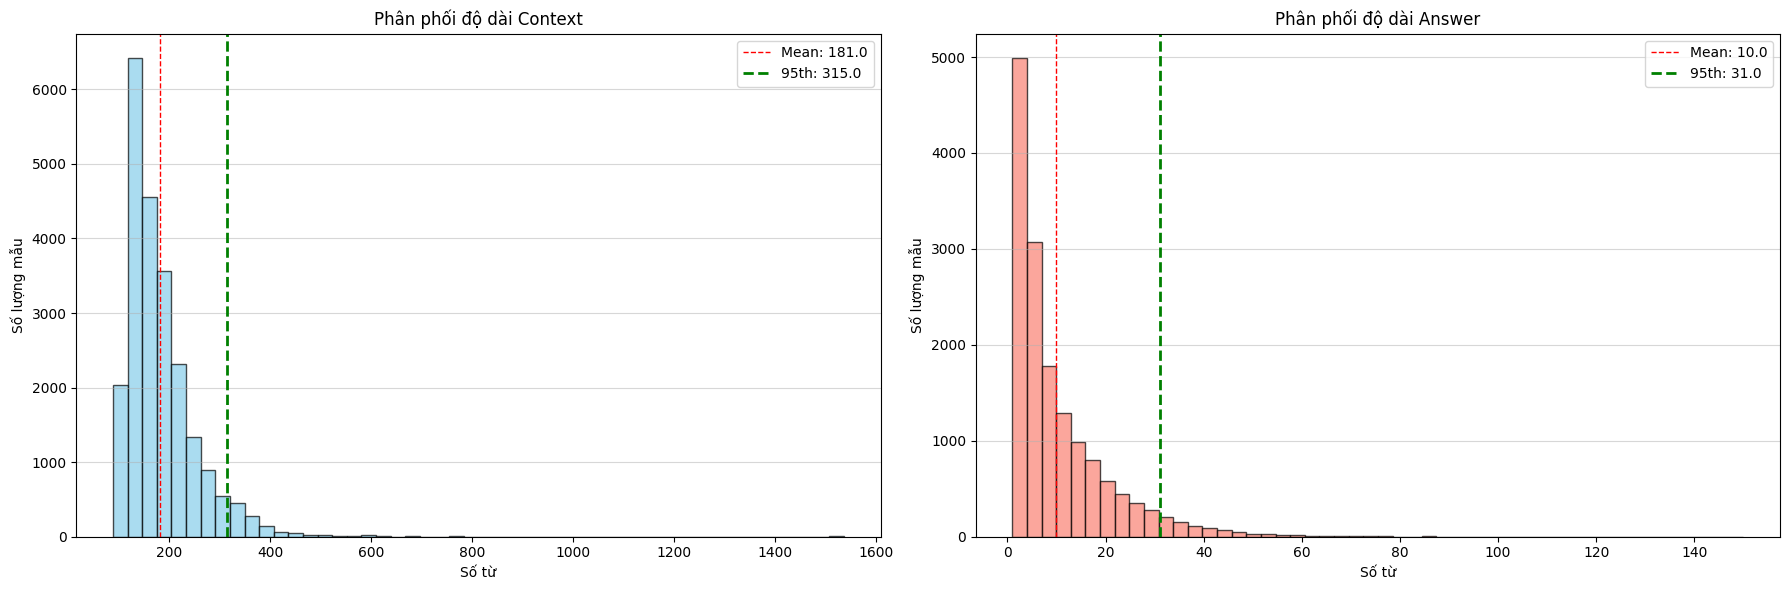

Selected MAX_LENGTH: 365


In [5]:
def analyze_data_lengths(dataset, dataset_name="Train"):
    """
    Phân tích và visualize thống kê độ dài của cả Context và Answer trong dataset.
    Trả về ngưỡng 95th percentile của Context để chọn max_length.
    """
    # 1. Trích xuất dữ liệu
    contexts = dataset['context']
    answers_list = dataset['answers'] # List các dict {'text': [...], 'answer_start': [...]}
    
    # 2. Tính độ dài (theo số từ - word count)
    context_lengths = [len(c.split()) for c in contexts]
    
    answer_lengths = []
    for ans in answers_list:
        # Một câu hỏi có thể có nhiều câu trả lời tham khảo, ta lấy tất cả
        for text in ans['text']:
            answer_lengths.append(len(text.split()))

    # Hàm phụ để in thống kê và vẽ lên trục (axes) cụ thể
    def plot_on_axis(lengths, title, ax, color):
        mean_len = np.mean(lengths)
        max_len = np.max(lengths)
        min_len = np.min(lengths)
        p95 = np.percentile(lengths, 95)
        p99 = np.percentile(lengths, 99)
        
        print(f"--- Thống kê độ dài {title} (tập {dataset_name}) ---")
        print(f"Min: {min_len}")
        print(f"Mean: {mean_len:.2f}")
        print(f"Max: {max_len}")
        print(f"95th Percentile: {p95:.2f}")
        print(f"99th Percentile: {p99:.2f}")
        print("-" * 30)

        # Vẽ Hist
        ax.hist(lengths, bins=50, color=color, edgecolor='black', alpha=0.7)
        ax.axvline(mean_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.1f}')
        ax.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th: {p95:.1f}')
        ax.set_title(f'Phân phối độ dài {title}')
        ax.set_xlabel('Số từ')
        ax.set_ylabel('Số lượng mẫu')
        ax.legend()
        ax.grid(axis='y', alpha=0.5)
        
        return int(p95)

    # 3. Khởi tạo khung vẽ (1 hàng, 2 cột)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Visualize Context (bên trái)
    p95_context = plot_on_axis(context_lengths, "Context", axes[0], 'skyblue')
    
    # Visualize Answer (bên phải)
    plot_on_axis(answer_lengths, "Answer", axes[1], 'salmon')
    
    plt.tight_layout()
    plt.show()
    
    return p95_context

# --- CÁCH GỌI HÀM MỚI ---
# truyền trực tiếp biến dataset (đã load ở bước trên) vào:
suggested_len = analyze_data_lengths(train_dataset, dataset_name="Train")

# Cập nhật MAX_LENGTH
MAX_LENGTH = min(suggested_len + 50, 512)
if MAX_LENGTH < 256: MAX_LENGTH = 256 
print(f"Selected MAX_LENGTH: {MAX_LENGTH}")

In [6]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

# Lấy token từ Secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

# Thực hiện đăng nhập
login(token=hf_token)

# Zero-Shot Prompting Qwen/Qwen1.5-4B-Chat

In [ ]:
!rm -rf DS310_ViQA_Transformer
!git clone 'https://github.com/sonbui25/DS310_ViQA_Transformer.git'
!python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_LLM_inference.py \
  --model_name Qwen/Qwen1.5-4B-Chat \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --output_file qwen_zero_shot_predictions.json \
  --mode zero-shot \
  --max_length 512 \
  --auth_token hf_token \
  --max_new_tokens 64 \
  --batch_size 32 \
  --device cuda \
  --multi_gpu

Cloning into 'DS310_ViQA_Transformer'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 189 (delta 124), reused 127 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 626.89 KiB | 7.21 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Loading tokenizer: Qwen/Qwen1.5-4B-Chat
tokenizer_config.json: 1.29kB [00:00, 811kB/s]
vocab.json: 2.78MB [00:00, 50.0MB/s]
merges.txt: 1.67MB [00:00, 115MB/s]
tokenizer.json: 7.03MB [00:00, 164MB/s]
Loading model: Qwen/Qwen1.5-4B-Chat
config.json: 100%|█████████████████████████████| 662/662 [00:00<00:00, 7.57MB/s]
`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-05 19:35:33.233319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767641733.448143      84 cuda_dnn.cc:8579] Unab

## Result

# Zero-Shot Prompting vilm/vinallama-2.7b-chat

In [ ]:
!python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_LLM_inference.py \
  --model_name vilm/vinallama-2.7b-chat \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --output_file vina_zero_shot_predictions.json \
  --mode zero-shot \
  --max_length 512 \
  --auth_token hf_token \
  --max_new_tokens 64 \
  --batch_size 32 \
  --device cuda \
  --multi_gpu

Loading tokenizer: vilm/vinallama-2.7b-chat
tokenizer_config.json: 1.40kB [00:00, 6.52MB/s]
tokenizer.json: 2.67MB [00:00, 55.4MB/s]
special_tokens_map.json: 100%|█████████████████| 558/558 [00:00<00:00, 6.84MB/s]
Loading model: vilm/vinallama-2.7b-chat
config.json: 100%|█████████████████████████████| 682/682 [00:00<00:00, 6.33MB/s]
`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-05 20:37:24.203741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767645444.223476     149 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767645444.230161     149 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767645444.249455     149 computation_pl

# Few-Shot Prompting Qwen/Qwen1.5-4B-Chat

In [ ]:
!python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_LLM_inference.py \
  --model_name Qwen/Qwen1.5-4B-Chat \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --output_file qwen_few_shot_predictions.json \
  --mode few-shot \
  --num_shots 2 \
  --max_length 2048 \
  --max_new_tokens 64 \
  --batch_size 8 \
  --device cuda \
  --multi_gpu

Loading tokenizer: Qwen/Qwen1.5-4B-Chat
tokenizer_config.json: 1.29kB [00:00, 1.04MB/s]
vocab.json: 2.78MB [00:00, 12.3MB/s]
merges.txt: 1.67MB [00:00, 11.9MB/s]
tokenizer.json: 7.03MB [00:00, 15.9MB/s]
Loading model: Qwen/Qwen1.5-4B-Chat
config.json: 100%|█████████████████████████████| 662/662 [00:00<00:00, 6.40MB/s]
`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-06 02:06:04.162509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767665164.349112      74 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767665164.401052      74 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767665164.843336      74 computation_placer.cc:177] co

# Few-Shot Prompting vilm/vinallama-2.7b-chat

In [ ]:
!python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_LLM_inference.py \
  --model_name vilm/vinallama-2.7b-chat \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --output_file vina_few_shot_predictions.json \
  --mode few-shot \
  --num_shots 2 \
  --max_length 2048 \
  --max_new_tokens 64 \
  --batch_size 16 \
  --device cuda \
  --multi_gpu

Loading tokenizer: vilm/vinallama-2.7b-chat
Loading model: vilm/vinallama-2.7b-chat
`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-05 21:32:14.896603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767648734.915632     238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767648734.922066     238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767648734.938769     238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767648734.938800     238 computation_placer.cc:177] computation placer already registered. Please check linkage and